In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser ='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist.data , mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
print(X.shape)
print(y.shape) # every row contains  digits value that equal to same row of X

(70000, 784)
(70000,)


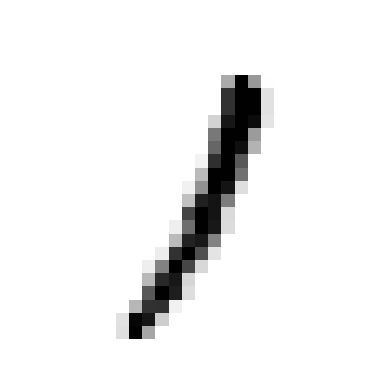

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def show_image(digit_values):
    
    image = digit_values.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show


some_digit = X[99]
show_image(some_digit)

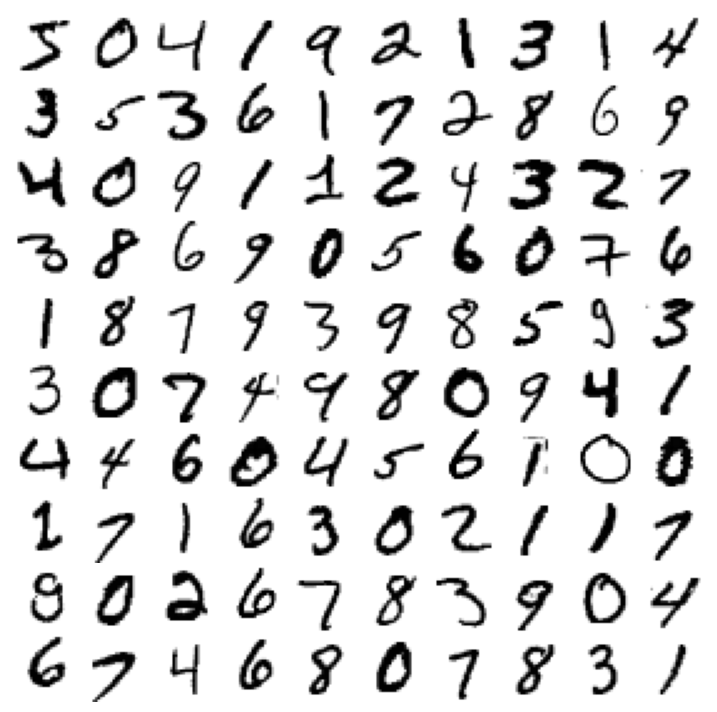

In [5]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    show_image(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [6]:
y = y.astype(np.uint8) # converting the y to integer numpy array
y[99]

1

In [7]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# Training a Binary Classifier
### 5 or not 5

In [8]:
y_test5 = (y_test == 5)
y_train5 = (y_train == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train5)

SGDClassifier(random_state=42)

#### Testing the model

In [10]:
some_digit_5 = X_train[0]
y_train[0]

5

In [11]:
some_digit_not5 = X_train[1]
y_train[1]

0

In [12]:
sgd_clf.predict([some_digit_5, some_digit_not5])

array([ True, False])

#### Nice we got the both right let's make a harder test
##### Measuring Accuracy Using Cross-Validation of sklearn

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### Measuring Accuracy Using Cross-Validation with our function

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  

In [15]:
for train_index, test_index in skfolds.split(X_train, y_train5):
    clone_cf = sgd_clf # deep copy the same model but without fitting (hyperparameter)

    X_train_folds = X_train[train_index]
    y_train_folds = y_train5[train_index]

    X_test_folds = X_train[test_index]
    y_test_folds = y_train5[test_index]

    clone_cf.fit(X_train_folds, y_train_folds)
    predictions = clone_cf.predict(X_test_folds)

    num_correct = sum(predictions == y_test_folds)
    accuracy = num_correct / len(y_test_folds)
    print(accuracy)

0.95035
0.96035
0.9604


#### Nice accuracy but let's try different model to find out if we are really doing well

In [16]:
# classifier that always predict not 5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never5 = Never5Classifier()
cross_val_score(never5, X_train, y_train5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [18]:
# Or we can use dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train5)
print(any(dummy_clf.predict(X_train)))

False


In [19]:
cross_val_score(dummy_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

#### From the previous two experiment we found that if or model always say not 5 we will get 90% accuracy, our sgd_clf model was getting about 93% so it's not doing a lot better than dummy classifier

# Confusion Matrix

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train5, cv =3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train5, y_train_pred)

0.6511713705958311

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train5, y_train_pred)

0.7325171197343846

#### precision / Recall Trade-off

In [25]:
y_scores_of_some5 = sgd_clf.decision_function([some_digit_5])
y_scores_of_some5

array([9840.07158362])

In [26]:
y_scores_not5 = sgd_clf.decision_function([some_digit_not5])
y_scores_not5

array([-27869.23727143])

#### We can say that Y score is number tells us how confident we are in a prediction, the default threshold of sklearn sgd_clf is 0,   so any Y_score above 0 will be classified as 5  

#### let's say we want to set threshold to 2200, we can't do this directly in sklearn, but we can get the y_score for any prediction and compare it with any threshold we want like this

In [27]:
threshold = 2200
passed_our_threshold = (y_scores_of_some5 > threshold)
passed_our_threshold

array([ True])

#### We know that y_scores_of_some5 is actually represent y score of a 5, but when we set the threshold to 2200 it didn't pass it

#### when setting the threshold to (N) we are saying we need the numbers that we are sure it's 5 by score higher of (N) (something like confidence interval)

In [28]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, method = 'decision_function')

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train5, y_scores) # precisions and recalls values to different thresholds

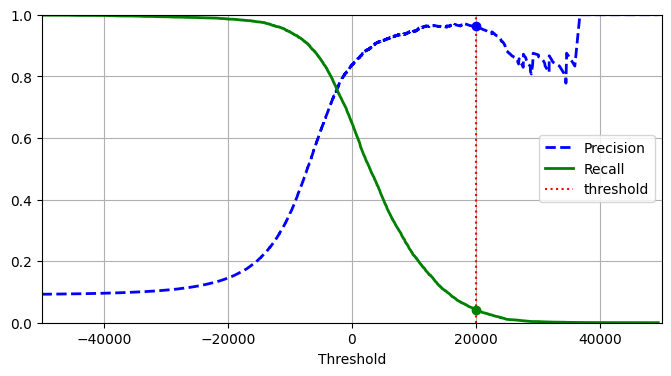

In [30]:
threshold = 20000

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "r", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

#### from the previous plot when setting the threshold to 20000 we are about 99% sure that any digit classified as 5 will actually be 5

![image.png](pre_rec.png)
#### This image can show why precision goes down in some threshold values, the reason is sometimes our model are more confident that (number is five and it's really not) more than (number is five and it's really five), like the  5 and 6 in the image

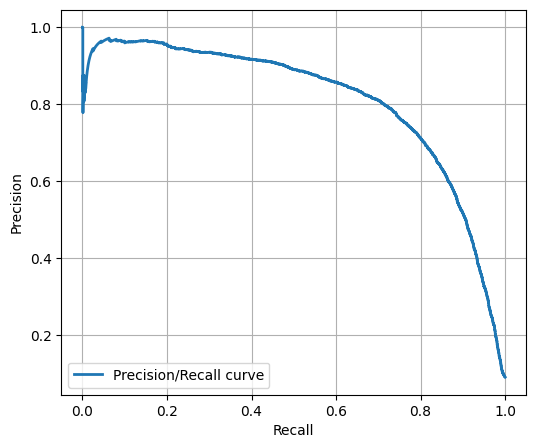

In [31]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

#### Now let's try our model in 0.90 precision

In [32]:
idx_for_90_precision = (precisions >= 0.90).argmax() # first index that have precision higher than .90

In [33]:
threshold_90_precision = thresholds[idx_for_90_precision]
threshold_90_precision

3370.0194991439557

In [34]:
y_pred_train_precision90 = (y_scores >= threshold_90_precision)

In [35]:

precision_score(y_train5, y_pred_train_precision90)

0.9000345901072293

In [36]:
recall_score(y_train5, y_pred_train_precision90)

0.4799852425751706

In [37]:
confusion_matrix(y_train5, y_pred_train_precision90)

array([[54290,   289],
       [ 2819,  2602]], dtype=int64)

#### Now let's try The Roc curve

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds_roc = roc_curve(y_train5, y_scores)

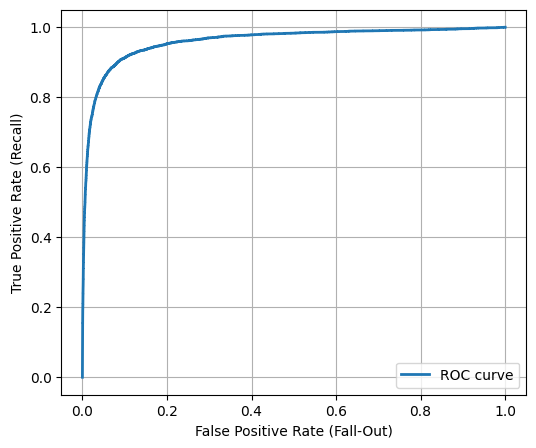

In [39]:


plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train5, y_scores)

0.9604938554008616

#### Comparing SGDClassifier With RandomForest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train5, cv=3, method="predict_proba")


In [42]:
y_prob_forest
# row will represent the probability of instance to be five in first column and 
# and not to be five in the second column

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [47]:
y_scores_forest = y_prob_forest[:,1] 
y_scores_forest 

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [48]:
# Not in the code
idx_50_to_60 = (y_prob_forest[:, 1] > 0.50) & (y_prob_forest[:, 1] < 0.60)
print(f"{(y_train5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")
# how many instance have prob of 50% to 60% are truly classified

94.0%


In [49]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train5, y_scores_forest)

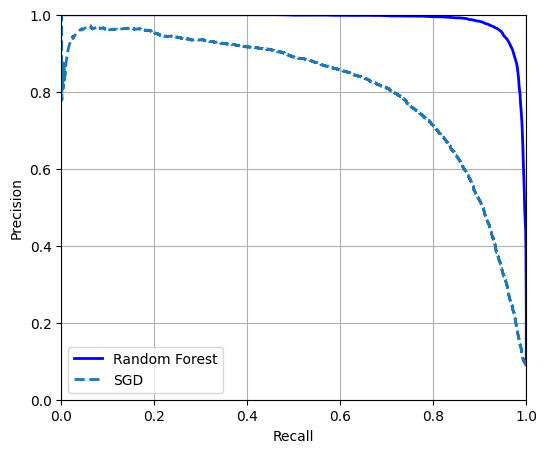

In [50]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
        label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [51]:
y_train_pred_forest = y_prob_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train5, y_train_pred_forest)

0.9274509803921569

In [52]:
roc_auc_score(y_train5, y_scores_forest)

0.9983436731328145

In [53]:
precision_score(y_train5, y_train_pred_forest)

0.9897468089558485

In [54]:
recall_score(y_train5, y_train_pred_forest)

0.8725327430363402

#### RandomForest is much better

# Multiclass Classification

In [55]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit_5])

array([5], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit_5])
some_digit_scores # the scores of how likely to be each class

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

### The previous algorithm trained in (OVO) one versus one technique, firstly one model tells the probability of each instance being 0 and another one compute the probability of being one and pick the one with the highest probability and take it to next competition with how likely this instance being 2 and so on for all classes and finally pick the one with the with the highest win rate against other classes.                

In [57]:
np.argmax(some_digit_scores)

5

#### the index five have the highest wins, and the number is actually five, so good jop model

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### let's measure the scores of this model

## Let's force the sklearn to use (OVR) One Versus the Rest Technique

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovr_SVC_clf = OneVsOneClassifier(SVC())
ovr_SVC_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC())

#### this way we can chose what technique to use in binary classifier to classify multiple classes, no let's use SGD classifier that is able to classify multi classes without needing one of this techniques

#### SGDClassifier

In [61]:
sgd_clf_mul = SGDClassifier(random_state=42)
sgd_clf_mul.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [72]:
cross_val_score(sgd_clf_mul, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


## Now i will leave the book for some time and try to optimize the model, try different solution, automate some steps etc...

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
knn_clf = KNeighborsClassifier()

cross_val_score(knn_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9376, 0.9411, 0.9424])

In [16]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9676 , 0.9671 , 0.96755])

In [17]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
baseline_accuracy = knn_clf.score(X_test, y_test)

In [21]:
baseline_accuracy

0.9688

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [23]:
grid_search.best_params_


{'n_neighbors': 4, 'weights': 'distance'}

In [24]:
grid_search.best_score_


0.9441999999999998

In [25]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

# 2. Data Augmentation


In [26]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [1]:
image = X_train[5]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
            interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
            interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
            interpolation="nearest", cmap="Greys")
plt.show()

NameError: name 'X_train' is not defined

In [33]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [34]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [35]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [36]:
knn_clf.fit(X_train_augmented, y_train_augmented)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [37]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [38]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


In [40]:
import joblib

joblib.dump(knn_clf, 'KNN_CLF_MNIST_SHIFTED')

['KNN_CLF_MNIST_SHIFTED']